# <p style="text-align: center;"> NISQAI: One-Qubit Quantum Classifier </p> 
<p style="text-align: center;"> Ryan LaRose, Yousif Almulla, Nic Ezzell, Joe Iosue, Arkin Tikku </p>

<blockquote cite="">
"Quantum computing needs more quantum software engineers to implement, test, and optimize quantum algorithms."
    -- Matthias Troyer.
</blockquote>

<blockquote cite="">
"Experimentation on quantum testbeds is needed." -- John Preskill.
</blockquote>

![Header image, quantum circuits over a neural network.](./header.png)

# <p style="text-align: center;"> What is NISQAI? </p> 

Quantum machine learning is an exciting but conjectural field that lacks testing on quantum computers. NISQAI is a library written to facilitate research in artificial intelligence on current quantum computers and NISQ (noisy intermediate-scale quantum) devices. 

In this notebook, we demonstrate the steps toward a quantum neural network working as a simple classifier. We then demonstrate how easily the NISQAI library can facilitate this task.

# <p style="text-align: center;"> Requirements for this Notebook </p> 

Since you're reading this, you probably have a working installation of [Python](https://www.python.org/) and/or [Jupyter](http://jupyter.org/). In order to run this notebook, the following external packages are necessary. Installation instructions can be found by following the hyperlinks for each.

* [NumPy](http://www.numpy.org/)
* [SciPy](https://www.scipy.org/)
* [pyQuil](https://pyquil.readthedocs.io/en/stable/) 2.1.0
* [Matplotlib](https://matplotlib.org/)
* [QuTiP](http://qutip.org/docs/4.1/index.html) 4.1.0 (only for Bloch sphere visualization features)

In [1]:
# builtins
import time

# standard imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# library imports
from pyquil.quil import Program
from pyquil import api
import pyquil.gates as ops
from qutip import Bloch, ket

# option for notebook plotting
%matplotlib inline

# <p style="text-align: center;"> Quantum Neural Networks: A Five Step Process </p> 

To implement a neural network for classical data on a quantum computer (i.e., a _quantum neural network_), the following steps need to be performed.

1. Data encoding.
    * Encode the classical data into a form suitable for the quantum circuit.
1. State preparation.
    * Implement a quantum circuit preparing the state of a particular datum.
1. Unitary evolution.
    * Implement a parameterized gate sequence to transform the data.
1. Measurement/non-linearity.
    * Measure the state of the quantum data after unitary evolution to revert back to classical information.       * Non-linearity can be introduced at this point via classical processing.
1. Training/cost function.
    * Define a cost function and optimize the parameters of the unitary to minimize the cost.
    
In the rest of the notebook, we'll go over how to do each of these steps in turn for a simple classification problem. At the end of the notebook, we'll show how easily this can be done with the NISQAI library and discuss other features of NISQAI.

# <p style="text-align: center;"> Problem Description </p> 

The specific problem we look it in this notebook falls under the category of _supervised machine learning_. Specifically, we ask:

_Given $N$ data points $p = (x, y) \in \mathbb{R}^2$ with labels $z(p) = 1$ if $x \le 0.5$ and $z(p) = 0$ otherwise, learn the decision boundary and classify new points._

## <p style="text-align: center;"> 1. Data Encoding  </p> 

In order to run a quantum neural network on classical data, the classical data needs to be suitably encoded to allow it to be "uploaded" to a quantum computer. We demonstrate a simple encoding scheme below for $(x, y)$ Cartesian coordinates distributed uniformly in a unit square.

### <p style="text-align: center;"> Generating Data  </p> 

First we generate a random set of classical data. For reproducibility, we'll seed our random number generator.

In [2]:
# set random seed for reproducible results
SEED = 1059123109
np.random.seed(seed=SEED)

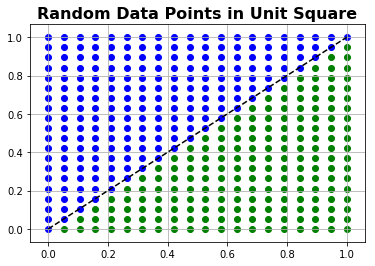

In [3]:
# generate data points distributed uniformly at random in [0, 1) x [0, 1)
npoints = 400
data = np.zeros((npoints, 2))
dx = np.linspace(0, 1, 20)

for j in range(20):
    data[j * len(dx) : (j + 1) * len(dx), 0] = dx[j]
    data[j * len(dx) : (j + 1) * len(dx), 1] = dx

def predicate(point):
    """Returns true if the point satisfies the predicate, else false."""
    return True if point[0] <= point[1] else False

# separate the data with a linear boundary y = x
labels = np.array([1 if predicate(p) else 0 for p in data])

# plot the line y = x
xs = np.linspace(0, 1, 100)
ys = 0.5 * np.ones_like(xs)
plt.plot(xs, xs, '--k')

# plot the data with the color key BLUE = 0 = LEFT, GREEN = 1 = RIGHT
for i in range(npoints):
    if labels[i] == 0:
        ckey = 'g'
    else:
        ckey = 'b'
    plt.scatter(data[i, 0], data[i, 1], color=ckey)
    
# title and axis lables
plt.title("Random Data Points in Unit Square", fontweight="bold", fontsize=16)

# put on a grid and show the plot
plt.grid()
# plt.savefig("graph.pdf", format="pdf")
plt.show()

### <p style="text-align: center;"> Qubit Encoding </p> 

Here we implement a method of data encoding that we call "qubit encoding." Qubit encoding works by writing two bits of classical information into one bit of quantum information. How is this done? Note that any qubit can be written

\begin{equation}
|\psi\rangle = \alpha |0\rangle + \beta |1\rangle
\end{equation}

where $\alpha, \beta \in \mathbb{C}$ satisfying $|\alpha|^2 + |\beta|^2 = 1$. Because of this normalization condition, we may equivalently write

\begin{equation}
|\psi\rangle = \cos(\theta / 2) |0\rangle + e^{i \phi} \sin(\theta / 2)|1\rangle
\end{equation}

We then encode information into the phases $0 \le \theta \le \pi$ and $ 0 \le \phi \le 2 \pi$. 

For the $(x, y)$ coordinates of our points, we will use the encoding

\begin{align}
\theta &= \pi x \\
\phi &= 2 \pi y
\end{align}

This is a simple encoding, but the results of the classification will speak to it's effectivenss. Other encodings, for example

\begin{align}
\theta &= \frac{1}{2} \tan^{-1}\left( \frac{y}{x} \right) \\
\phi &= \pi (x^2 + y^2),
\end{align}

can be used for other data sets.

In code, we may make this transformation as follows:

In [4]:
# encode the classical data via a simple linear "qubit encoding"
qdata = np.zeros_like(data)
for (index, point) in enumerate(data):
    qdata[index][0] = np.pi * (point[0] + 0.0 * point[1]) / 1.0
    qdata[index][1] = 2 * np.pi * (0.0 * point[0] + point[1]) / 1.0
#     qdata[index][0] = np.pi * point[0]
#     qdata[index][1] = 2 * np.pi * point[1]
#     qdata[index][0] = 2 * np.arcsin(point[0])
#     qdata[index][1] = 4 * np.arccos(point[1])

It's now possible to visualize the data as points on the surface of the Bloch sphere.

<IPython.core.display.Javascript object>


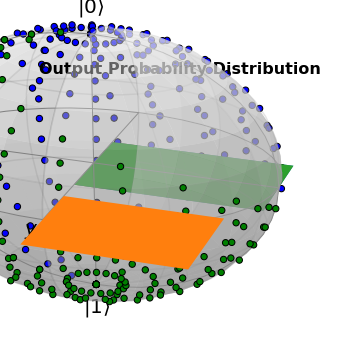

In [8]:
# break the data into two lists depending on label and turn into (x, y, z) points

# empty lists to store values
gxs = []
gys = []
gzs = []
bxs = []
bys = []
bzs = []

# loop over all points, convert to cartesian coords, and append to correct list
for (index, point) in enumerate(qdata):
    theta = point[0]
    phi = point[1]
    sin = np.sin(theta)
    # convert to cartesian coords for plotting
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    if labels[index] == 0:
        gxs.append(x)
        gys.append(y)
        gzs.append(z)
    else:
        bxs.append(x)
        bys.append(y)
        bzs.append(z)

# format points correctly for bloch sphere
lpoints = [gxs, gys, gzs]
rpoints = [bxs, bys, bzs]

# get a Bloch sphere
bloch = Bloch()

# options for Bloch sphere
bloch.frame_color = "grey"
bloch.sphere_color = "white"
bloch.point_size = [40]
bloch.sphere_alpha = 0.50
bloch.point_color = ["g", "b"]
bloch.point_marker = ["o"]
bloch.view = [-55, 10]

# add the points on the Bloch sphere
bloch.add_points(lpoints)
bloch.add_points(rpoints)
    
# show the Bloch sphere
#bloch.save("lin-comb-bloch.pdf", format="pdf")
%matplotlib notebook
bloch.show()

## <p style="text-align: center;"> 2. State Preparation </p> 

Now that we have encoded our data, we still need to prepare it in quantum form. Conventionally, all qubits start in the $|0\rangle$ state. The problem we have to solve is:

Given angles $\theta, \phi$, perform the mapping

\begin{equation}
S(\theta, \phi) |0\rangle \rightarrow |\psi\rangle = \cos(\theta / 2) |0\rangle + e^{i \phi} \sin(\theta / 2)|1\rangle
\end{equation}

We call $S$ a _state preparation unitary_ or _state preparation circuit_.

It is clear from the equation above that the matrix representation for $S$ in the computational basis is

\begin{equation}
S(\theta, \phi) = \left[ \begin{matrix} 
\cos(\theta / 2) & e^{-i \phi} \sin(\theta / 2)\\
e^{i \phi} \sin(\theta / 2) & - \cos(\theta / 2)  \\
  \end{matrix} \right]
\end{equation}

On current NISQ computers, circuits need to be as short-depth as possible, meaning they contain as few gates as possible. The "qubit encoding" performed above allows for a constant-depth state preparation circuit for any given values of $\theta, \phi$.

Why is this? In general we need to perform some arbitrary unitary transformation $S \in SU(2)$. It is known that such a unitary can be implemented with five standard rotations that can be implemented by current quantum computers. Namely,

\begin{equation}
S = R_z(\gamma_1) R_x(\pi / 2) R_z(\gamma_2) R_x(\pi / 2) R_z(\gamma_3)
\end{equation}

where $0 \le \gamma_i \le 2 \pi$ for $i = 1, 2, 3$. We can define our gate $S$ above in pyquil and compile it to a sequence of five implementable rotations by using the Quil compiler. First we'll write a function to give us our state preparation matrix. 

In [9]:
# define the matrix S as a function of theta and phi
def state_prep_mtx(theta, phi):
    """Returns the state preparation matrix according to the qubit encoding above."""
    return np.array([[np.cos(theta / 2), np.exp(-1j * phi) * np.sin(theta / 2)],
                     [np.exp(1j * phi) * np.sin(theta / 2), - np.cos(theta / 2)]])

Next we'll define this as a pyquil gate. We do this by first making a program then defining a gate for a particular encoded data point.

In [10]:
# get a pyquil program
qprog = Program()

# pick a particular encoded data point
theta, phi = qdata[0]

# get the state prep matrix for this point
S = state_prep_mtx(theta, phi)

# define a gate in pyquil for the state preparation
qprog.defgate("S", state_prep_mtx(theta, phi))

We can now use this gate in a quantum program to input our classical data into the quantum computer. To do this, we simply write:

In [11]:
# prepare the first encoded data point in quantum form
qprog += ("S", 0)

To see our program, we can print it out:

In [12]:
print(qprog)

DEFGATE S:
    1.0, 0.0
    0.0, -1.0

S 0



If we measure this qubit now, we get either a zero or a one with probability proportional to it's amplitudes. We'll add this measurement to our program and then run it many times to get an estimate of the probability distribution of it's outcome.

In [13]:
# add a measurement on the qubit encoding our data
creg = qprog.declare("ro", memory_size=1)
qprog += (ops.MEASURE(0, creg[0]))

# print out the new program
print(qprog)

DEFGATE S:
    1.0, 0.0
    0.0, -1.0

S 0
DECLARE ro BIT[1]
MEASURE 0 ro[0]



In [14]:
# run the program many times
shots = 1000
qvm = api.QVMConnection()
dist = qvm.run(qprog, trials=shots)

In [15]:
def histogram(dist):
    """Makes a histogram of the probability of obtaining 0 and 1."""
    # get the zero and one probabilities
    prob0 = dist.count([0]) / shots
    prob1 = dist.count([1]) / shots
    
    # make a bar plot
    plt.bar([0, 1], [prob0, prob1])
    
    # make it look nice
    plt.grid()
    plt.title("Output Probability Distribution", fontsize=16, fontweight="bold")
    plt.xlabel("Measurement Outcomes", fontsize=14)
    plt.ylabel("Probability", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks([0, 1])
    
    # show it
    plt.show()

# make a histrogram of the output distribution
histogram(dist)

We want our output distribution to move towards either zero or one, depending on what label is assigned to that particular data point. To do this, we implement unitary evolution on the circuit, which corresponds to implementing another sequence of gates in our circuit.

## <p style="text-align: center;"> 3. Unitary Evolution </p> 

After the classical data has been encoded (step 1) and prepared into the quantum system (step 2), step 3 is to perform unitary evolution on the quantum state representing the data. In the language of classical learning theory, this corresponds to implementing a layer of the neural network.

In the quantum neural network case, we simply need to implement a sequence of parameterized gates.

First we write a function to easily implement such a unitary.

In [16]:
def unitary(angles):
    """Returns a circuit implementing the unitary Rz(theta0) P Rz(theta1) P Rz(theta2)
    where thetea0 = angles[0], theta1 = angles[1], and theta2 = angles[2] and
    P = Rx(pi / 2) is a pi / 2 pulse.
    """
    return Program(
        ops.RZ(angles[0], 0),
        ops.RX(np.pi / 2, 0),
        ops.RZ(angles[1], 0),
        ops.RX(np.pi / 2, 0),
        ops.RZ(angles[2], 0)
    )

Next we use it to add unitary evolution to our quantum neural network for some given angles.

In [17]:
# test angles
angles = 2 * np.pi * np.random.rand(3)

# pop off measurement
qprog.pop()

# append the unitary circuit to our quantum neural network program
qprog += unitary(angles)
qprog += [ops.MEASURE(0, creg[0])]

In [18]:
print(qprog)

DEFGATE S:
    1.0, 0.0
    0.0, -1.0

S 0
DECLARE ro BIT[1]
RZ(5.975955791599168) 0
RX(pi/2) 0
RZ(0.7898055544158503) 0
RX(pi/2) 0
RZ(3.6262412296857174) 0
MEASURE 0 ro[0]



Now we'll run this new circuit with the unitary evolution implemented.

In [19]:
# run the quantum neural network program
histogram(qvm.run(qprog, trials=shots))

Now we want to use this unitary evolution to move our output probability towards the desired label. We'll suppose for a moment that this point is supposed to be mapped to the 0 output. We'll define an objective function ```obj_simple(angles)``` to capture the amount of 1 outputs, then we'll train over the angles in the unitary to minimize the objective.

In [20]:
def make_program(pangles, uangles):
    """Returns a pyquil program that prepares the state according
    to pangles and applies the unitary according to uangles.
    """
    # instantiate a program
    qprog = Program()
    creg = qprog.declare("ro", memory_size=1)
    
    # define a gate in pyquil for the state preparation
    qprog.defgate("S", state_prep_mtx(pangles[0], pangles[1]))

    # write the program(
    qprog += [("S", 0),
             unitary(uangles),
             ops.MEASURE(0, creg[0])]
    
    return qprog

def obj_simple(angles, shots=1000, verbose=False):
    """Returns the number of zero outputs of a single training example."""
    # make the program
    qprog = make_program([theta, phi], angles)
    if verbose:
        print(qprog)
    dist = qvm.run(qprog, trials=shots)
    obj = dist.count([1]) / shots
    print("The current value of the objective function is:", obj, end="\r")
    return obj

Now we'll minimize the objective function `obj_simple` by using the modifed `Powell` algorithm builtin to SciPy. The minimization here should take no more than 30 seconds.

In [21]:
out = minimize(obj_simple, x0=2 * np.pi * np.random.rand(3), method="Powell")

Now we can verify that the output distribution skews this point towards the "zero bin."

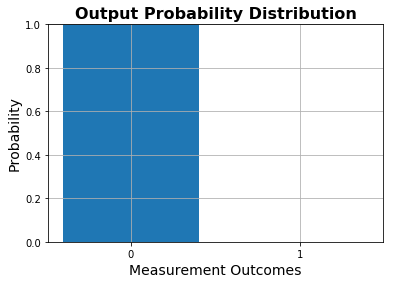

In [23]:
# do the circuit (neural network) with the optimal parameters
%matplotlib inline
opt_angles = out['x']
qprog = make_program([theta, phi], opt_angles)

# show the output distribution
dist = qvm.run(qprog, trials=shots)
histogram(dist)

Indeed it does! Here we demonstrated that we can use our neural network to "steer" a point in a particular direction. The idea of training is to "steer" _all_ points in the desired direction. Before we train our quantum neural network, we first discuss the measurement process and it's importance in quantum neural network implementations.

## <p style="text-align: center;"> 4. Measurement  </p> 

Measurement is used in our circuit above to translate from quantum to classical information. In other quantum neural networks, measurement can be used to introduce non-linearity.

NISQAI treats measurements as both a way to keep circuit-depth low (for implementations on current/near-term quantum computers) as well as introduce non-linearity between layers of a network. Specifically, measuremnets lead to (intermediate) classical data. On a classical computer, we can introduce any non-linear activation function we wish. The new classical data from the output of the activation function can then be prepared into quantum form again via steps 1 and 2 (data encoding and state preparation).

This intermediate classical post-processing is a trademark of NISQAI. It allows for:

1. Short-depth circuits suitable for NISQ computers.
1. Non-linearity between layers of a quantum neural network.
1. Deep learning (many layers) with shallow circuits.

In this simple binary classifier example, we'll restrict to just one layer of the neural network for simplicity.

## <p style="text-align: center;"> 5. Training </p> 

We saw above that it's easy to steer one point towards the output we want to get. But training the quantum neural network involves training over all points in the training set. For this, we need to define a cost function that captures the total loss over the entire training set.

To do this, define the _indicator function_ $I(z_i = \hat{z}_i)$ to be 0 if $z_i = \hat{z}_i$ and 1 otherwise. Here, $z_i$ is the exact label of the $i$th training data $(x_i, y_i)$ and $\hat{z}_i$ is the prediction of this label by our neural network. (In code, we use the variables `labels` for $z_i$ and `predictions` for $\hat{z}_i$.)

To define the cost now, we simply sum over all points (say there are $M$ points) in the training data:

\begin{equation}
C = \sum_{i = 1}^{M} I(z_i = \hat{z}_i)
\end{equation}

Note that the cost $C$ depends on the unitary evolution $U$, i.e. $C = C(U)$, because the prediction $\hat{z}_i$ depends on $U$. 

We now need to define a cost (objective) function ```obj(...)``` that takes into account all data in the training set. This function will encapsulate everything we've done for a single training point, but now for all of them.

In [24]:
# fraction of total data to use as training data
train_frac = 0.7

def obj(uangles):
    """Returns the objective function C defined above over all training data.
    
    Args:
        uangles [type: list<float>]
            the angles in the unitary evolution.

    rtype: int
    """
    # grab some training data from the overall data set
    tpoints = int(train_frac * len(qdata))
    tdata = qdata[:tpoints]
    tlabels = labels[:tpoints]
    
    # initialize a variable to store the output predictions of the neural net
    predictions = np.zeros_like(tlabels, dtype=int)
    
    # loop over all training data to get the predictions
    for i, pangles in enumerate(tdata):
        # write the program
        qprog = make_program(pangles, uangles)
        
        # run the program
        out = qvm.run(qprog, trials=1000)
        
        # get the output probabilities
        p0 = out.count([0])
        p1 = out.count([1])
        
        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            predictions[i] = 0
        else:
            predictions[i] = 1
        
    # compute the difference of the labels and return the cost
    cost = sum(abs(predictions - tlabels)) / tpoints
    print("The current value of the cost function is:", cost, end="\r")
    return cost

Now let's compute the objective function for some random test angles.

In [25]:
# get some random angles
angs = 2 * np.pi * np.random.rand(3)
cost = obj(angs)

We don't want just any random angles for our unitary evolution, however. We want to compute the optimal angles, which we can do by minimizing the cost function. Again we'll use the modified ```Powell``` algorithm for minimization.

Training the neural network here will take more time than simply optimizing the output of a single point. On our computer, it takes around 15 seconds to evaluate the objective function for one set of angles. The `Powell` optimization algorithm generally takes on the order of 20-30 cost function evaluations--for us the optimization takes around 15 minutes on average. You can expect this training to take 15-20 minutes.

If you're in a hurry and don't want to wait for this training, we've saved a set of optimal angles from previous attempts. These angles are for a horizontal boundary $x = 0.5$ trained on 70/100 data points. They will only be optimal for the first set of random points generated by the given seed. We reiterate: _Only use these angles if you haven't changed anything in the notebook and only ran each cell once!_

In [26]:
optimal_angles = [7.85082205, 0.01934754, 9.62729993]

If you chose to skip the training, you should *not* execute the next two cells. Otherwise, continue through the notebook.

In [ ]:
# train the quantum neural network and time how long it takes
start = time.time()
out = minimize(fun=obj, x0=angs, method="Powell")
print("\nTotal training runtime took {} minutes.".format((time.time() - start) / 60))

In [ ]:
# grab the optimal angles and minimal cost value
optimal_angles = out['x']
fval = out['fun']

# print them out
print(fval)
print(optimal_angles)

# <p style="text-align: center;"> Results  </p> 

Now that we've trained on a subset of our data, we can see how the predictions do on the whole dataset.

First, we'll write a function that performs this task.

In [27]:
def get_all_predictions(angles):
    """Returns a numpy array of all predictions."""
    # initialize a variable to store the output predictions of the neural net
    zhats = np.zeros_like(labels, dtype=int)
    
    # loop over all data to get predictions
    for i, pangles in enumerate(qdata):
        # write the program
        qprog = make_program(pangles, angles)
        
        # run the program
        out = qvm.run(qprog, trials=1000)
        
        # get the output probabilities
        p0 = out.count([0])
        p1 = out.count([1])
        
        # take the prediction to be max(p0, p1)
        if p0 >= p1:
            zhats[i] = 0
        else:
            zhats[i] = 1
    return zhats

Then we'll call the function to get the results.

In [ ]:
# compute all the predictions of the quantum neural network
predictions = get_all_predictions([0, 0, 0])#optimal_angles)

We have now trained our neural network and classifeid all data points. Let's display the statistics below to see how our QNN performed.

In [ ]:

num = 0

for a in np.linspace(0, 2 * np.pi, 50):
    for b in np.linspace(0, 2 * np.pi, 50):
        num += 1
        
        # compute all the predictions of the quantum neural network
        predictions = get_all_predictions([a, b, 0])

# # compute statistics of the QNN
# ntrain = int(train_frac * npoints)
# ncorrect = npoints - sum(abs(predictions - labels))
# acc = ncorrect / npoints * 100

# # print them out
# print(" Results of quantum neural network classification ".center(80, "="))
# print("Out of {} total data points:".format(npoints))
# print("The QNN was trained on {}% of the total data ({} training points).".format(train_frac * 100, ntrain))
# print("The QNN classified {} data points correctly ({}% accuracy).".format(ncorrect, acc))
# print("".center(80, "="))
# % matplotlib inline
# # plot the points, line y = x, and prediction
# #plt.plot(xs, xs, '--k')
        for i in range(npoints):
            if predictions[i] == 0:
                ckey = 'g'
            else:
                ckey = 'b'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        plt.grid()
        plt.title("a = %0.2f, b = %0.2f" %(a, b), fontsize=16, fontweight="bold")
        plt.savefig(str(num) + ".pdf", format="pdf")

## <p style="text-align: center;"> Discussion of Results </p> 

How did your quantum neural network perform? If you followed through this notebook sequentially, you should have seen 100% accuracy in the predictions of the network. A saved plot of our results obtained by running this notebook is included below: 

![QNN Predictions](qnn-predictions.png)

Here, the exact decision boundary (not the learned one) is shown in the plot, and data points are colored according to the quantum neural network predictions. Blue means predicted left of the boundary (0 bin), and green means predicted right of the boundary (1 bin). As can be seen in our example results, all data points are correctly classified.

# <p style="text-align: center;"> Example Done with NISQAI  </p> 

The above example involved five steps to implementing a neural network on a quantum computer. While the steps aren't hard, programming each one for every particular example is tedious and time consuming. More time could be spent testing quantum neural networks if there were a library to implement all of these steps.

This is where NISQAI comes in. NISQAI is to quantum machine learning what TensorFlow/pyTorch is to classical machine learning. Just like OpenFermion provides a library of code to simplify quantum chemistry on quantum computers, NISQAI provides a library of code to simplify neural networks and other machine learning algorithms on quantum computers.

The above classifier example in NISQAI could be done with the following few lines of code. Here, we assume that ```classical_data``` exists in the program.

## Prototype NISQAI Code

```
# imports
from nisqai import qnn

# get a quantum neural network
network = qnn.qnn(nodes=1, layers=1)

# encode the classical data into quantum form
network.encode(data=classical_data, scheme=qnn.encoding_schemes.SIMPLE_LINEAR)

# add the unitary evolution
network.add_unitary(qnn.ansatze.UNIVERSAL)

# add measurements to the network
network.add_measurements(basis=qnn.bases.Z)

# do the training on 70% of the total data
network.train(optimizer="Powell", fraction=0.7)

# test the neural network on all the data or on new input data
statistics = network.classify()
```

These few lines of code show the power of NISQAI. One of it's greatest strengths is the flexibility to research other quantum neural network implementations, not just the one qubit quantum classifier.

## Features of NISQAI

* Shatters domain barriers.
    * Whether you're a machine learning researcher interested in quantum or a quantum researcher interested in machine learning, NISQAI is built for you.
* Powerful builtins.
    * Numerous prototypes of quantum neural network architectures, including methods for data encoding, state preparation, unitary evolution, measurement, and training.
* Fully modular.
    * For methods like `qnn.add_unitary(...)`, the user can write a function to specify whichever unitary ansatz is desired.
* Loaded with examples.
    * Many instructive code snippets and notebooks to get you started in quantum machine learning.
* Open-source.
    * NISQAI is currently under development with expected release in early 2019. After this, NISQAI will be free and open-source. Always.
* Cross platform.
    * NISQAI works for Windows, Mac, and Linux.
* Python/Matlab interfaces.
    * Two of the most popular languages for quantum computing and machine learning researchers.

# Conclusions

In this example, we've seen that a quantum neural network is able to successfully classify classical data in $\mathbb{R}^2$. The qubit encoding strategy is able to write two bits of classical information into one bit of quantum information. Additionally, the state preparation circuit for the qubit encoding is short-depth, particularly useful for NISQ computers. We've demonstrated how to train a quantum neural network using the modified Powell algorithm on a simple example. We've also discussed how the NISQAI library greatly simplifies quantum neural network implementations.

# Acknowledgements

The development of NISQAI is supported by the [unitary.fund](http://unitary.fund/). We thank [Will Zeng](https://twitter.com/wjzeng) for creating and running this program, as well as [John Hering](https://twitter.com/johnhering), Jeff Cordova, Nima Alidoust, and [PLOS](https://www.plos.org/) for sponsoring it.